In [1]:
%matplotlib inline

In [22]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp as smm
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

In [3]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [4]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

djf_df.reset_index(inplace=True)
jja_df.reset_index(inplace=True)
mam_df.reset_index(inplace=True)
son_df.reset_index(inplace=True)

del djf_df['index']
del jja_df['index']
del mam_df['index']
del son_df['index']

djf_df.columns = ['year', 'season', 'seaice_conc']
jja_df.columns = ['year', 'season', 'seaice_conc']
mam_df.columns = ['year', 'season', 'seaice_conc']
son_df.columns = ['year', 'season', 'seaice_conc']

del djf_df['season']
del jja_df['season']
del mam_df['season']
del son_df['season']

In [5]:
# Define the knots
knots = [1917, 1944, 1995]

In [6]:
def linear_splines(data, knots, degree=1):
    minyr = data.year.min()
    nyrs = data.year.shape[0]

    # Use indices of years for knots
    minyr = data.year.min()
    knots2 = [k-minyr for k in knots]
    
    # Column vector for beta1 are (t1, t2,...,tn)
    X1 = np.arange(nyrs)
    X1 = X1[:, np.newaxis]
    
    # Generate design matrix
    X2 = np.zeros((nyrs, len(knots2)))
    for col, k in enumerate(knots2):
        X2[k:, col] = np.abs(X2[k:, col] - X1[:nyrs-k, 0])
    X = np.hstack((X1, X2))
    return smf.glm('seaice_conc ~ X', data=data).fit()

In [7]:
jja_spl = linear_splines(jja_df, knots)
son_spl = linear_splines(son_df, knots)

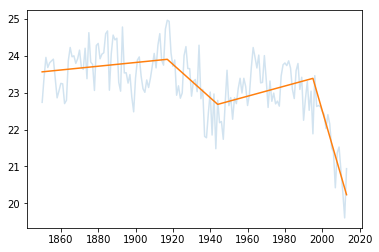

In [8]:
plt.plot(jja_df.year, jja_df.seaice_conc, alpha=0.2)
plt.plot(jja_df.year, jja_spl.fittedvalues)

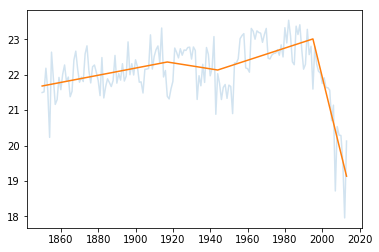

In [9]:
plt.plot(son_df.year, son_df.seaice_conc, alpha=0.2)
plt.plot(son_df.year, son_spl.fittedvalues)

In [10]:
# Estimates
nyrs = yr_avg.shape[0]
nparams = len(knots) + 2

mu_hat = jja_spl.mu
R = jja_spl.resid_response.values
cov = jja_spl.cov_params()
sigma_hat2 = np.sum(R**2) / (nyrs-nparams)
pvals = jja_spl.pvalues.values

In [11]:
jja_spl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            seaice_conc   No. Observations:                  164
Model:                            GLM   Df Residuals:                      159
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                  0.329561950114
Method:                          IRLS   Log-Likelihood:                -139.15
Date:                Tue, 27 Jun 2017   Deviance:                       52.400
Time:                        23:16:30   Pearson chi2:                     52.4
No. Iterations:                     2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.5673      0.133    177.729      0.000      23.307      23.827
X[0]           0.0051      0.003      1.627      0.104      -0.001       0.011
X[1]          -0.0503      0.009     -5.571      0.000      -0.068      -0.033
X[2]           0.0591      0.010      5.948      0.000       0.040       0.079
X[3]          -0.1891      0.019     -9.922      0.000      -0.226      -0.152
==============================================================================
"""

In [12]:
rej, pval_corr = smm.multipletests(pvals, method='bonferroni')[:2]

In [13]:
rej

array([ True, False,  True,  True,  True], dtype=bool)

In [21]:
pvals

array([  0.00000000e+00,   1.03774193e-01,   2.53674729e-08,
         2.72049463e-09,   3.34659336e-23])

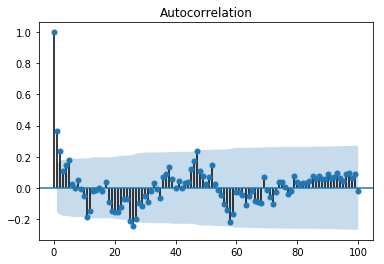

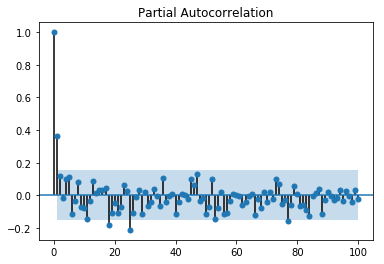

In [28]:
acf = plot_acf(R, lags=100)
pacf = plot_pacf(R, lags=100)

In [24]:
x = tsa.acf(R, nlags=10)

array([ 1.        ,  0.3642397 ,  0.23420376,  0.10600597,  0.14342696,
        0.18061792,  0.02727045, -0.00401881,  0.04823144, -0.00668951,
       -0.0501655 ])